In [1]:
import sframe                                                  # see below for install instruction
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1491189292.log
INFO:sframe.cython.cy_server:SFrame v2.1 started. Logging /tmp/sframe_server_1491189292.log


In [2]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

wiki = sframe.SFrame('people_wiki.gl/')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

In [3]:
tf_idf = normalize(tf_idf)

In [4]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [5]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


In [10]:
distances=pairwise_distances(tf_idf,tf_idf[0:3,:],metric='euclidean')

In [11]:
dist=distances[430,1]

In [12]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [15]:
closest_cluster=distances.argmin(axis=1)

In [16]:
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [17]:
cluster_assignment=closest_cluster

In [18]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [26]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data,centroids,metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = distances_from_centroids.argmin(axis=1)
    
    return cluster_assignment

In [27]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


# filtering

In [28]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [29]:
cluster_assignment = assign_clusters(data, centroids)
print cluster_assignment   # prints [0 1 0]

[0 1 0]


In [30]:
print data[cluster_assignment==1]

[[ 0.  0.  0.]]


In [31]:
print data[cluster_assignment==0]

[[ 1.  2.  0.]
 [ 2.  2.  0.]]


In [32]:
print data[cluster_assignment==0].mean(axis=0)

[ 1.5  2.   0. ]


In [33]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [35]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [61]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [41]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data,k,cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [42]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

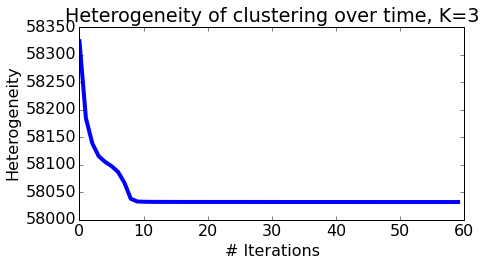

In [52]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [53]:
import itertools
import operator

def most_common(L):
  # get an iterable of (item, iterable) pairs
  SL = sorted((x, i) for i, x in enumerate(L))
  # print 'SL:', SL
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    # print 'item %r, count %r, minind %r' % (item, count, min_index)
    return count, -min_index
  # pick the highest-count/earliest item
  return max(groups, key=_auxfun)[0]

In [47]:
#quiz 4
print (cluster_assignment==0).sum()
print (cluster_assignment==1).sum()
print (cluster_assignment==2).sum()

19595
10427
29049


In [54]:
print most_common(cluster_assignment)

2


In [55]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
        
    # To save time, compute heterogeneity only once in the end
    
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    print "most",(cluster_assignment==most_common(cluster_assignment)).sum()
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
most 18047
seed=020000, heterogeneity=57533.20100
most 15779
seed=040000, heterogeneity=57512.69257
most 18132
seed=060000, heterogeneity=57466.97925
most 17900
seed=080000, heterogeneity=57494.92990
most 17582
seed=100000, heterogeneity=57484.42210
most 16969
seed=120000, heterogeneity=57554.62410
most 16481
252.586762905


In [57]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [58]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
375.484364033


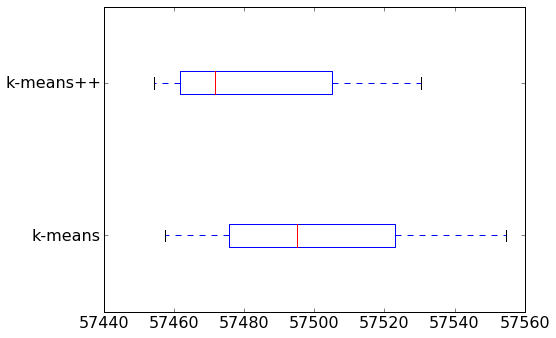

In [59]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [62]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter,
                                       record_heterogeneity=heterogeneity, verbose=True)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] =  compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

2
10
25
50
100


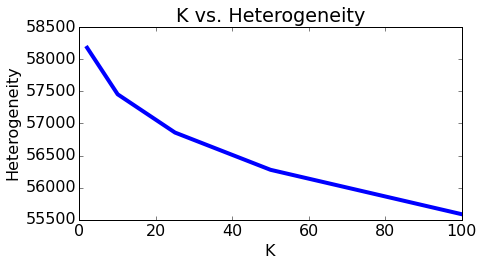

In [63]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [64]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(wiki[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [65]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0     she:0.025 her:0.017 music:0.012 he:0.011 university:0.011 

* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                         

In [66]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0     film:0.020 art:0.014 he:0.011 book:0.010 television:0.010 

* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823
  paul swadel is a new

In [67]:
np.bincount(cluster_assignment[10])

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,  8926])

In [68]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0     law:0.077 district:0.048 court:0.046 republican:0.038 senate:0.038 
Cluster 1     research:0.054 professor:0.033 science:0.032 university:0.031 physics:0.029 
Cluster 2     hockey:0.216 nhl:0.134 ice:0.065 season:0.052 league:0.047 
Cluster 3     party:0.065 election:0.042 elected:0.031 parliament:0.027 member:0.023 
Cluster 4     board:0.025 president:0.023 chairman:0.022 business:0.022 executive:0.020 
Cluster 5     minister:0.160 prime:0.056 cabinet:0.044 party:0.043 election:0.042 
Cluster 6     university:0.044 professor:0.037 studies:0.035 history:0.034 philosophy:0.031 
Cluster 7     election:0.066 manitoba:0.058 liberal:0.051 party:0.045 riding:0.043 
Cluster 8     racing:0.095 formula:0.056 championship:0.054 race:0.052 poker:0.051 
Cluster 9     economics:0.146 economic:0.096 economist:0.053 policy:0.048 research:0.043 
Cluster 10     championships:0.075 olympics:0.050 marathon:0.048 metres:0.048 she:0.048 
Cluster 11     she:0.144 her:0.092 miss:0.016 actress:0

In [69]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0     brazilian:0.137 brazil:0.082 de:0.056 rio:0.053 paulo:0.050 
Cluster 1     bishop:0.170 diocese:0.085 archbishop:0.083 church:0.072 ordained:0.058 
Cluster 2     zealand:0.247 new:0.069 auckland:0.056 wellington:0.031 zealands:0.029 
Cluster 3     comics:0.181 comic:0.121 strip:0.042 graphic:0.036 book:0.034 
Cluster 4     puerto:0.309 rico:0.220 rican:0.066 juan:0.041 ricos:0.031 
Cluster 5     bbc:0.192 radio:0.127 presenter:0.054 show:0.046 news:0.042 
Cluster 6     senate:0.059 district:0.053 county:0.051 committee:0.049 state:0.044 
Cluster 7     labor:0.105 australian:0.099 liberal:0.071 election:0.067 seat:0.061 
Cluster 8     economics:0.065 university:0.048 research:0.045 professor:0.043 economic:0.043 
Cluster 9     foreign:0.086 ambassador:0.076 affairs:0.061 nations:0.053 united:0.040 
Cluster 10     she:0.188 her:0.052 women:0.026 womens:0.020 council:0.019 
Cluster 11     rowing:0.246 sculls:0.097 rower:0.081 olympics:0.073 championships:0.068 
Cluster 12   

In [72]:
x=np.bincount(cluster_assignment[100])
(x<236).sum()

29